## Comparación Modelos: Clasificación

### Carga de Datos

Importamos las librerías necesarias y los datos para poder comparar diferentes modelos sobre un mismo problema de clasificación. En este caso el problema consiste en clasificar una serie de vinos italianos en función de varias propiedades químicas de estos. Es un dataset sencillo para que los modelos no tarden en entrenarse, pero dado el escaso número de instancias no es el mejor ejemplo para aplicar determinados algoritmos que tienden a sobreajustarse con pocos datos.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler


In [2]:
df = pd.read_csv("./data/vinos_italianos.csv")

In [3]:
df.head()

,wine_class,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   wine_class                    178 non-null    int64  
 1   Alcohol                       178 non-null    float64
 2   Malic acid                    178 non-null    float64
 3   Ash                           178 non-null    float64
 4   Alcalinity of ash             178 non-null    float64
 5   Magnesium                     178 non-null    int64  
 6   Total phenols                 178 non-null    float64
 7   Flavanoids                    178 non-null    float64
 8   Nonflavanoid phenols          178 non-null    float64
 9   Proanthocyanins               178 non-null    float64
 10  Color intensity               178 non-null    float64
 11  Hue                           178 non-null    float64
 12  OD280/OD315 of diluted wines  178 non-null    float64
 13  Proli

In [5]:
target = "wine_class"

In [6]:
df[target].value_counts(normalize= True)

wine_class
2    0.398876
1    0.331461
3    0.269663
Name: proportion, dtype: float64

Es un dataset equilibrado, limpio y preparado al que únicamente tendremos que escalar las variables para los modelos sensibles a dicha escala en nuestro caso la regresión logística

In [7]:
train_set, test_set = train_test_split(df, test_size= 0.2, random_state= 42)

In [8]:
features = train_set.columns.to_list()
features.remove(target)
scaler = StandardScaler()
X_train = train_set[features]
y_train = train_set[target] - 1
X_test = test_set[features]
y_test = test_set[target] - 1
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns= features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns = features)

### Modelos

Vamos a escoger todos los modelos que hemos visto de clasificación y los vamos a probar todos:

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

model_names = ["Logistic Regression","DecisionTree","Random Forest","XGBoost","LightGBM","CatBoost"]
lr_clf = LogisticRegression(max_iter = 10000)
tree_clf = DecisionTreeClassifier(random_state= 42)
rf_clf = RandomForestClassifier(random_state= 42)
xgb_clf = XGBClassifier(random_state = 42)
lgb_clf = LGBMClassifier(random_state= 42, verbose = -100)
cat_clf = CatBoostClassifier(random_state= 42, verbose = False)

model_set = [lr_clf, tree_clf, rf_clf, xgb_clf, lgb_clf, cat_clf]


### Comparación con Validación Cruzada (pre-optimización)


In [10]:
metricas_cv = {}
valores = []
for nombre,modelo in zip(model_names, model_set):
    print(modelo)
    if nombre != "Logistic Regression":
        metricas_cv[nombre] = cross_val_score(modelo, X_train, y_train, cv = 3, scoring = "accuracy")
    else:
        metricas_cv[nombre] = cross_val_score(modelo, X_train_scaled, y_train, cv = 3, scoring = "accuracy")
    valores.append(np.mean(metricas_cv[nombre]))
ganador = list(metricas_cv.keys())[np.argmax(valores)]

LogisticRegression(max_iter=10000)
DecisionTreeClassifier(random_state=42)
RandomForestClassifier(random_state=42)
XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)
LGBMClassifier(random_state=42, verbose=-100)


In [11]:
for model_name, valores in metricas_cv.items():
    print(f"Model <{model_name}>, Accuracy_CV: {np.mean(valores)}")
print(f"El ganador es {ganador}")

Model <Logistic Regression>, Accuracy_CV: 0.978871158392435
Model <DecisionTree>, Accuracy_CV: 0.9222813238770685
Model <Random Forest>, Accuracy_CV: 0.9858156028368793
Model <XGBoost>, Accuracy_CV: 0.9645390070921986
Model <LightGBM>, Accuracy_CV: 0.9716312056737588
Model <CatBoost>, Accuracy_CV: 0.9787234042553191
El ganador es Random Forest


### Optimizacion del Ganador


In [12]:

params_grid = {
    "n_estimators": [100,200,400],
    "max_depth": [2,4,10],
    "min_samples_leaf": [10,20,40],
    "max_features": ["sqrt","log2",None],
    "max_samples": [0.3,0.6,1]
}

rf_grid = GridSearchCV(rf_clf,
                       param_grid= params_grid,
                       cv = 3,
                       scoring = "accuracy",
                       n_jobs = -1)

rf_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 10],
                         'max_features': ['sqrt', 'log2', None],
                         'max_samples': [0.3, 0.6, 1],
                         'min_samples_leaf': [10, 20, 40],
                         'n_estimators': [100, 200, 400]},
             scoring='accuracy')

In [13]:
rf_grid.best_score_

np.float64(0.9858156028368793)

In [14]:
rf_grid.best_params_

{'max_depth': 2,
 'max_features': 'sqrt',
 'max_samples': 0.6,
 'min_samples_leaf': 10,
 'n_estimators': 100}

              precision    recall  f1-score   support

           0       0.93      1.00      0.97        14
           1       1.00      0.86      0.92        14
           2       0.89      1.00      0.94         8

    accuracy                           0.94        36
   macro avg       0.94      0.95      0.94        36
weighted avg       0.95      0.94      0.94        36



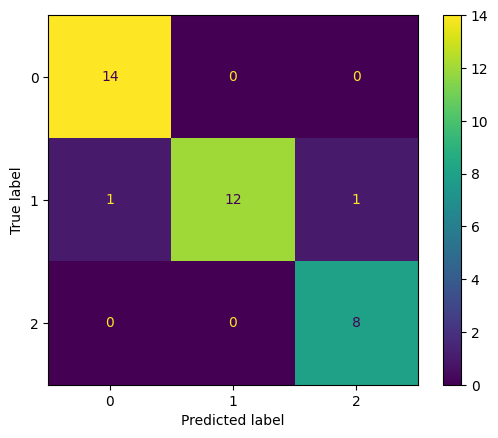

In [15]:
y_pred = rf_grid.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

### Comparación con Optimización previa

Una alternativa a hacer una validación cruzada sin optimizar es hacer una comparativa de modelos semi-optimizados mediante una estrategia de RandomSearch.  
La idea es combinar la capacidad de comparativa de la validación cruzada pero haciendo que los modelos puedan aprovechar relativamente un poco de optimización de hiperparámetros y no hacerlo a la primera con cada uno.


In [16]:
metricas_optimizadas = {}

In [17]:
### Logistic Regression
LogisticRegression
param_grid = {
    "max_iter": [1000, 2000, 5000, 10000],
    "penalty": ["l2",None],
    "C": [0.1,0.5,1],

} # 4*3*3 -> 36 modelos
model = LogisticRegression()
lr_grid = RandomizedSearchCV( model,
                             cv = 3, # 36*3 -> 108 entrenamientos en gridsearch
                             n_iter = 20,
                             param_distributions= param_grid,
                             scoring= "accuracy"
)

lr_grid.fit(X_train_scaled,y_train)
print("LR best_score:", lr_grid.best_score_)
metricas_optimizadas["LogisticRegression"] = lr_grid.best_score_

h:\RepoBootcamp\RepoEjercicios\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
h:\RepoBootcamp\RepoEjercicios\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
h:\RepoBootcamp\RepoEjercicios\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
h:\RepoBootcamp\RepoEjercicios\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
h:\RepoBootcamp\RepoEjercicios\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
h:\RepoBootcamp\RepoEjercicios\venv\Lib\site-packages\sklearn\lin

LR best_score: 0.9859633569739952


h:\RepoBootcamp\RepoEjercicios\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
h:\RepoBootcamp\RepoEjercicios\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [18]:
### DecisionTrees

tree_clf = DecisionTreeClassifier()

param_grid = {
    "max_depth": [1,2,4,8,None],
    "min_samples_leaf": [1,5,10,20],
    "max_features": ["sqrt","log2", None]
}

tree_grid = RandomizedSearchCV(tree_clf, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "accuracy")

tree_grid.fit(X_train,y_train)
print("Tree best_score:", tree_grid.best_score_)
metricas_optimizadas["Tree"] = tree_grid.best_score_

Tree best_score: 0.9156323877068558


In [19]:
### RandomForest

rf_clf = RandomForestClassifier()

params_grid = {
    "n_estimators": [100,200,400],
    "max_depth": [2,4,10],
    "min_samples_leaf": [10,20,40],
    "max_features": ["sqrt","log2",None],
    "max_samples": [0.3,0.6,1]
}

rf_grid = RandomizedSearchCV(rf_clf, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "accuracy")


rf_grid.fit(X_train, y_train)
print("RF best_score:", rf_grid.best_score_)
metricas_optimizadas["RandomForest"] = rf_grid.best_score_

RF best_score: 0.9787234042553191


In [20]:
### XGBoost

xgb_clf = XGBClassifier()

param_grid = {'max_depth': [3, 6, 10, 15],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'subsample': np.arange(0.5, 1.0, 0.1),
          'colsample_bytree': np.arange(0.5, 1.0, 0.1),
          'colsample_bylevel': np.arange(0.5, 1.0, 0.1),
          'n_estimators': [100, 250, 500, 750],
          }

xgb_grid = RandomizedSearchCV(xgb_clf, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "accuracy")


xgb_grid.fit(X_train, y_train)
print("XGB best_score:", xgb_grid.best_score_)
metricas_optimizadas["XGBoost"] = xgb_grid.best_score_

XGB best_score: 0.9929078014184397


In [21]:
### LightGBM 


lgb_clf = LGBMClassifier(verbose = -100)

param_grid= {'max_depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          'bagging_fraction': [0.3,0.6,1],
          'feature_fraction': [0.5,1],
          'n_estimators': [100, 250, 500, 750],
          'max_bins': [125,250]
          }

lgb_grid = RandomizedSearchCV(lgb_clf, 
                               cv = 3,
                               n_iter = 20,
                               param_distributions= param_grid, 
                               scoring = "accuracy")


lgb_grid.fit(X_train, y_train)
print("LGB best_score:", lgb_grid.best_score_)
metricas_optimizadas["LightGBM"] = lgb_grid.best_score_

LGB best_score: 0.9929078014184397


In [22]:
### CatBoost

cat_clf = CatBoostClassifier(verbose = False)

param_grid= {'depth': [3, 6, 12],
          'learning_rate': [0.1, 0.2, 0.3, 0.4],
          #'bagging_fraction': [0.3,0.6,1], No hay hiperparámetro equivalente
          'colsample_bylevel': [0.5,1],
          'iterations': [100, 250, 500, 750],
          "border_count": [125,250]
          }


cat_grid = RandomizedSearchCV(cat_clf, 
                               cv = 3,
                               n_iter = 3,
                               param_distributions= param_grid, 
                               scoring = "accuracy")


cat_grid.fit(X_train, y_train)
print("CatBoost best_score:", cat_grid.best_score_)
metricas_optimizadas["CatBoost"] = cat_grid.best_score_

CatBoost best_score: 0.9787234042553191
